In [1]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)
import torch
import pandas as pd
import numpy as np
import statsmodels.api as sm
from signal_generator.synthesizer_builder import SynthesizerBuilder
from models.model_factory import ModelFactory

/opt/anaconda3/bin/python


## TODO

- Add random outliers (spikes) into random places in the signal 
- Add random noise into the signal
- How to simulate rotation
- Have functionality to render real data
- Read more about synthetic MRI signal generation
- Evaluate the optimizer and learning rate impacts
- Look into simulating multiple regions
- [X]Use regular autoencoder instead of VAE
- [X]Simulate the confounds
- [X]Simulate cosine waves to simulate different frequencies (hear rate and high frequency)
- [X]Could an autoencoder return the beta values? (many cosine waves with one parameter and a bottleneck of 1)
- [X]Think about how RNN could be used to learn the beta values (Could use a Recurrent CNN approach)

## Synthesize Brain Data

HR wave:  (500,)
Task signal shape:  (315,)
Task signal shape:  (420,)
Signal shape:  (500, 2)
Design matrix:  (500, 5)


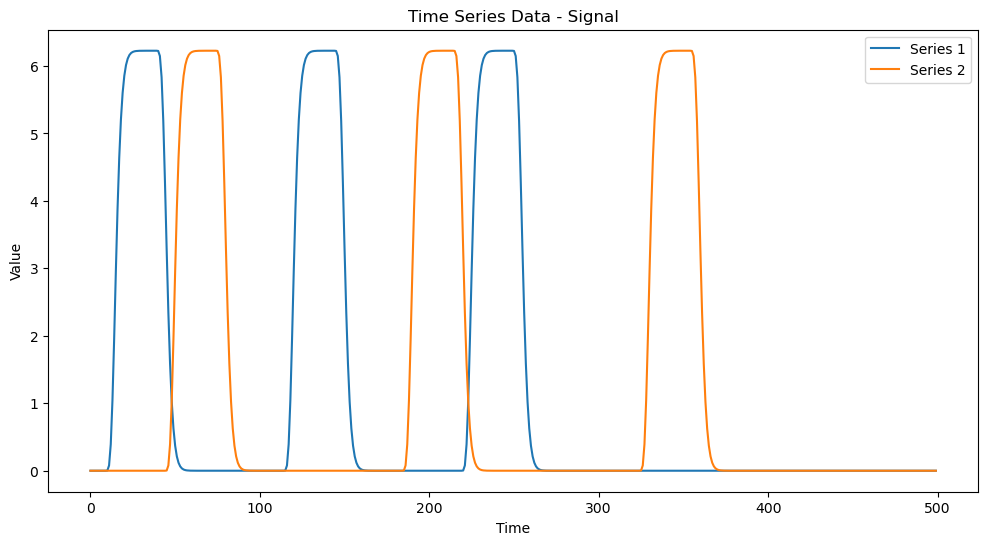

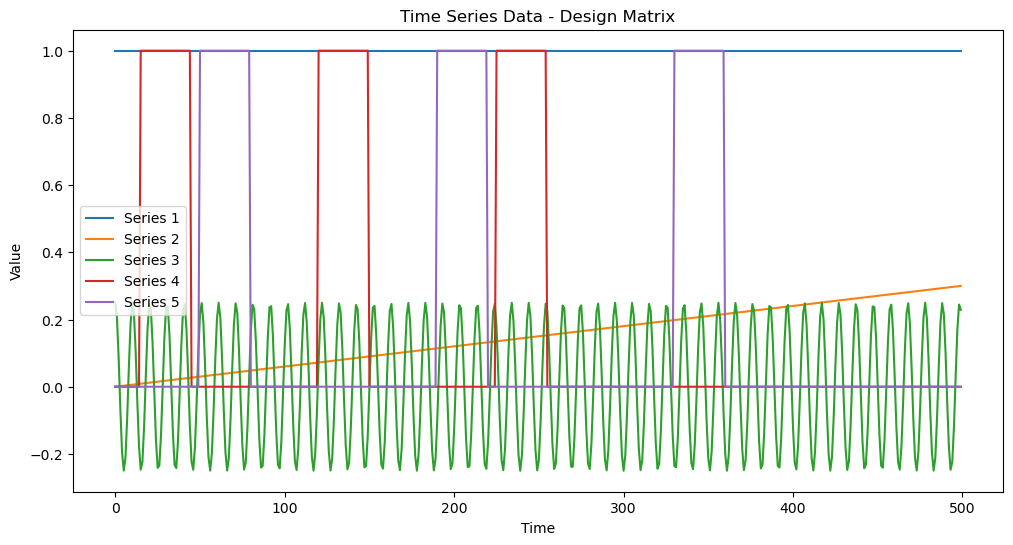

Y_true:  [ 4.00000000e+00  3.44633887e+00  1.98857858e+00  1.65999074e-01
 -1.34724289e+00 -1.99135530e+00 -1.52787085e+00 -1.27810327e-01
  1.69154523e+00  3.25789779e+00  3.99248671e+00  3.62406155e+00
  2.28916566e+00  4.81654969e-01 -1.12988484e+00  1.05067981e+00
  1.32663462e+00  2.59629013e+00  4.39057716e+00  6.04646573e+00
  6.95209296e+00  6.77297407e+00  5.57566426e+00  3.80315269e+00
  2.11108557e+00  1.12536811e+00  1.21076195e+00  2.33602967e+00
  4.08548348e+00  5.81266864e+00  6.87936331e+00  6.89153468e+00
  5.84501630e+00  4.12704843e+00  2.37311201e+00  1.23198586e+00
  1.12588756e+00  2.09437597e+00  3.77972598e+00  5.55918257e+00
  6.77519870e+00  6.97853613e+00  6.09435266e+00  4.44987195e+00
  2.65340611e+00 -1.63054257e+00 -1.92695378e+00 -1.12590833e+00
  4.76773767e-01  2.28890053e+00  3.64084648e+00  4.03311895e+00
  3.32102483e+00  1.76816486e+00 -5.10218421e-02 -1.46363286e+00
 -1.94708032e+00 -1.32229613e+00  1.80065024e-01  2.00490067e+00
  3.47788675e+00

In [2]:
%reload_ext autoreload
# Create a Synthesizer with custom parameters using the builder
synth_builder = SynthesizerBuilder()
synth = (synth_builder
       .add_length(500)
       .add_intercept()
       .add_drift(0, 0.3)
       .add_heart_rate()
       .add_signal(30, 60, 3, 15, "1")
       .add_signal(30, 60, 3, 50, "2")
       .build())
signal, design_matrix = synth.get()
print("Signal shape: ", signal.shape)
print("Design matrix: ", design_matrix.shape)
synth.plot_signal()
synth.plot_design_matrix()

# Get the GLM Values
beta_values_target = np.array([1, 1.5, 12, 3, 0])
# print(design_matrix.shape, beta_values.shape)
y_true = np.dot(design_matrix, beta_values_target)
print("Y_true: ", y_true, type(y_true), y_true.shape)

## Basic AE Data

Design matrix:  (500, 7)


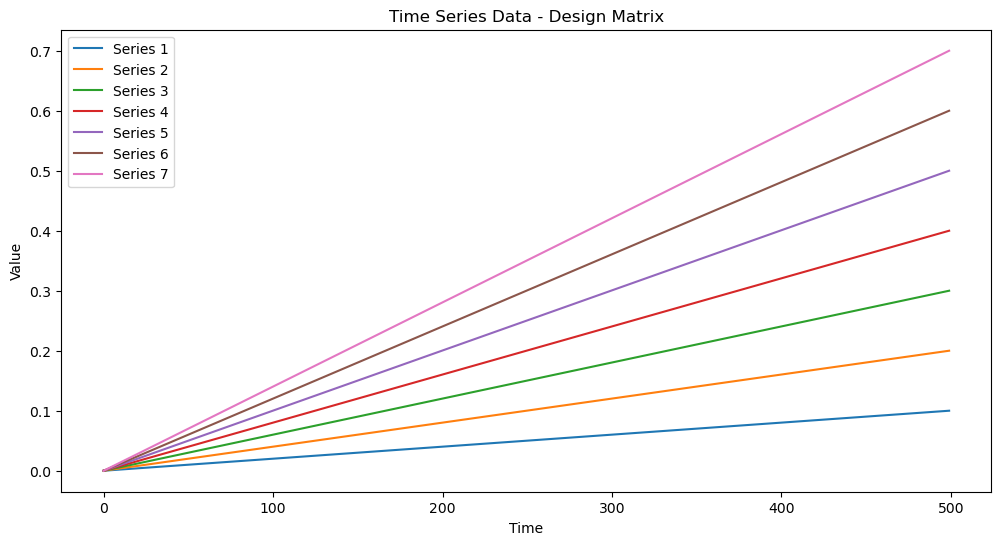

In [2]:
synth_builder = SynthesizerBuilder()
ae_synth = (synth_builder
       .add_length(500)
       .add_drift(0, 0.1)
       .add_drift(0, 0.2)
       .add_drift(0, 0.3)
       .add_drift(0, 0.4)
       .add_drift(0, 0.5)
       .add_drift(0, 0.6)
       .add_drift(0, 0.7)
       .build())
ae_signal, ae_design_matrix = ae_synth.get()
print("Design matrix: ", ae_design_matrix.shape)
ae_synth.plot_design_matrix()

## Deep learning implementation

### Simple matrix multiplication version

In [4]:
# Use Factory pattern to get models
BoldGLM = ModelFactory.create_model('glm', design_matrix)

# Run the model
print(signal.shape)
# TODO - DESIGN MATRIX SHAPE SHOULD BE (400, 1)
# model, losses = BoldGLM.train_bold_glm(design_matrix, y_true)
model, losses = BoldGLM.train_model(design_matrix, signal[:, 1])

beta_values = model.get_betas()
print("Target: ", beta_values_target)
print("Learned: ", beta_values.flatten())

(500, 2)
Epoch [1/20000], Loss: 7.2905
Converged at epoch 826 with loss: 0.2593
Target:  [ 1.   1.5 12.   3.   0. ]
Learned:  [ 0.22189379 -0.57086176 -0.0328104  -0.16645311  5.6354685 ]


### Recurrent CNN Version

In [5]:
# Import the model
SeqCNN = ModelFactory.create_model('cnn', design_matrix)

# Run the model
print(signal.shape)
#Train with beta generated signal
model, losses = SeqCNN.train_model(design_matrix, signal[:, 1])

# Train with generated signal
# model, losses = BoldGLM.train_bold_glm(design_matrix, signal)

beta_values = model.get_betas()
print("Target: ", beta_values_target)
print("Learned: ", beta_values.flatten())

data_shape:  [[1.00000000e+00 0.00000000e+00 2.50000000e-01 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 6.01202405e-04 2.03786422e-01 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 1.20240481e-03 8.22312478e-02 0.00000000e+00
  0.00000000e+00]
 ...
 [1.00000000e+00 2.98797595e-01 1.70245264e-01 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 2.99398798e-01 2.44822133e-01 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 3.00000000e-01 2.28886149e-01 0.00000000e+00
  0.00000000e+00]]
(500, 2)
Target:  [ 1.   1.5 12.   3.   0. ]
Learned:  tensor([-0.7443,  0.5434, -0.1871,  0.2315, -0.5786], grad_fn=<ViewBackward0>)


## Variational Autoencoder Version

In [6]:
# Run the model
print(ae_design_matrix.T.shape)
# Create the model
VAE = ModelFactory.create_model('variational_autoencoder', ae_design_matrix.shape)

# Train the model
model = VAE.train(ae_design_matrix.T, learning_rate=0.001, n_epochs=2000)

# Get the latent value
x_sample = torch.FloatTensor(ae_design_matrix.T)
latent_values = model.get_latent_value(x_sample)
print("Learned latent value: ", latent_values, latent_values.shape)

(7, 500)
Epoch [0/2000], Loss: 418.5050
Epoch [100/2000], Loss: 40.7981
Epoch [200/2000], Loss: 52.6462
Epoch [300/2000], Loss: 35.5137
Epoch [400/2000], Loss: 59.2104
Epoch [500/2000], Loss: 22.7884
Epoch [600/2000], Loss: 34.8988
Epoch [700/2000], Loss: 30.2165
Epoch [800/2000], Loss: 26.3910
Epoch [900/2000], Loss: 17.5883
Epoch [1000/2000], Loss: 20.4293
Epoch [1100/2000], Loss: 26.7848
Epoch [1200/2000], Loss: 13.4288
Epoch [1300/2000], Loss: 15.1687
Epoch [1400/2000], Loss: 26.0066
Epoch [1500/2000], Loss: 21.8415
Epoch [1600/2000], Loss: 31.7815
Epoch [1700/2000], Loss: 20.8729
Epoch [1800/2000], Loss: 18.0216
Epoch [1900/2000], Loss: 21.5851
Learned latent value:  tensor([[ 2.1659],
        [ 0.1817],
        [-0.9728],
        [ 0.2076],
        [ 0.0114],
        [-0.0239],
        [ 0.0511]]) torch.Size([7, 1])


## Autoencoder

In [43]:
# print("Y_true: ", y_true, type(y_true), y_true.shape)
# ae_design_matrix = np.concatenate([design_matrix, signal], axis=1)

# Run the model
print(ae_design_matrix.shape)
# Create the model
autoencoder = ModelFactory.create_model('autoencoder', ae_design_matrix.shape)

# Train the model
model = autoencoder.train(ae_design_matrix.T, learning_rate=0.00075, n_epochs=800)

# Get the latent value
x_sample = torch.FloatTensor(ae_design_matrix.T)
latent_values = model.get_latent_value(x_sample)
print("Learned latent value: ", latent_values, latent_values.shape)

(500, 7)
X_train shape:  torch.Size([7, 500])
Epoch [0/800], Loss: 0.1156
Epoch [10/800], Loss: 0.0913
Epoch [20/800], Loss: 0.0484
Epoch [30/800], Loss: 0.0325
Epoch [40/800], Loss: 0.0260
Epoch [50/800], Loss: 0.0217
Epoch [60/800], Loss: 0.0177
Epoch [70/800], Loss: 0.0141
Epoch [80/800], Loss: 0.0108
Epoch [90/800], Loss: 0.0075
Epoch [100/800], Loss: 0.0046
Epoch [110/800], Loss: 0.0025
Epoch [120/800], Loss: 0.0013
Epoch [130/800], Loss: 0.0008
Epoch [140/800], Loss: 0.0005
Epoch [150/800], Loss: 0.0004
Epoch [160/800], Loss: 0.0003
Epoch [170/800], Loss: 0.0003
Epoch [180/800], Loss: 0.0002
Epoch [190/800], Loss: 0.0002
Epoch [200/800], Loss: 0.0002
Epoch [210/800], Loss: 0.0002
Epoch [220/800], Loss: 0.0001
Epoch [230/800], Loss: 0.0001
Epoch [240/800], Loss: 0.0001
Epoch [250/800], Loss: 0.0001
Epoch [260/800], Loss: 0.0001
Epoch [270/800], Loss: 0.0001
Epoch [280/800], Loss: 0.0001
Epoch [290/800], Loss: 0.0001
Epoch [300/800], Loss: 0.0001
Epoch [310/800], Loss: 0.0000
Epoch

## Ground Truth - Prebuilt GLM

In [8]:
# Define and fit the GLM model
model = sm.GLM(signal[:, 1], design_matrix, family=sm.families.Gaussian())
results = model.fit()

# Output the summary of the model
print(results.summary())
print("Beta values: ", results.params)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      495
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                         0.26190
Method:                          IRLS   Log-Likelihood:                -372.01
Date:                Tue, 03 Dec 2024   Deviance:                       129.64
Time:                        12:10:12   Pearson chi2:                     130.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2210      0.059      3.722      0.0